In [1]:
from train_basic import *
import os
import shutil
import models
from timm.models import create_model
from models.modules.mobileone import reparameterize_model
import torch
import torch.nn as nn
import torchvision
from dataset_basic import get_transforms, load_data, get_data_loaders
from label_smooth import LabelSmoothingCrossEntropy
import models
# import torch.nn as nn
# from AdamW import AdamW
# from onecycle import OneCycleLR

#path = './透明_by_CCD/1站'
#path = '大峰2034-07-19-NG/透明'
path = '1020_NG_膠囊_by_CCD/CCD1'
#path = 'CCD2_original_combine_foreground_in_right__rotate90_and-90'
#path = 'CCD1_original_combine_foreground_in_right__rotate90_and-90'
#path = './AAA123/CCD8/Part'
#path = './透明_combine'

##################### to reomove .ipynb_checkpoints #################
# Set the path to the folder
#folder_path = './AAA123/CCD8/Part'
#folder_path = './透明_combine'
#folder_path = './透明_by_CCD/1站'
folder_path = '1020_NG_膠囊_by_CCD/CCD1'
#folder_path = 'CCD1_original_combine_foreground_in_right__rotate90_and-90'

# Checkpoint folder name
checkpoint_folder = '.ipynb_checkpoints'

# Full path to the checkpoint folder
checkpoint_path = os.path.join(folder_path, checkpoint_folder)

# Remove the folder
if os.path.exists(checkpoint_path):
    shutil.rmtree(checkpoint_path)
    print(f"Removed {checkpoint_path}")
else:
    print(f"{checkpoint_path} does not exist")

######################## END #######################################
    
bs = 16  # Batch size

transformer = get_transforms()
train, val, test, original = load_data(path, transformer)
loaders = get_data_loaders(train, val, test, bs)

dataset_sizes = {
    'train': len(train),
    'val': len(val),
    'test': len(test),
}
num_epochs = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Initialize model
# mobilenet_v3_large = torchvision.models.mobilenet_v3_large(pretrained=True)

# for param in mobilenet_v3_large.parameters():
#     param.requires_grad = False

# Replace the last layer in the classifier
# in_features = mobilenet_v3_large.classifier[-1].in_features
# out_features = len(original.classes) # original should come from dataset.py
# mobilenet_v3_large.classifier[-1] = nn.Linear(in_features=in_features, out_features=out_features, bias=True)

################################MogaNet####################################################################
# num_classes_original = len(original.classes)
# model = models.moganet_xtiny(pretrained=True)
# model_ft = model.to(device)
# # Set the device
# model_ft.head = nn.Linear(in_features=model.head.in_features, out_features=num_classes_original, bias=True)

#############################MogaNet#######################################################################

############################# ml-fasttvit #################################################################
num_classes_original = len(original.classes)
model = create_model("fastvit_t8")
# Load unfused pre-trained checkpoint for fine-tuning
# or for downstream task training like detection/segmentation
checkpoint = torch.load('fastvit_t8.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
#model.load_state_dict(checkpoint)
model_ft = model.to(device)
model_ft.head = nn.Linear(in_features=model.head.in_features, out_features=num_classes_original, bias=True)
#model_ft.linear = nn.Linear(in_features=model.linear.in_features, out_features=num_classes_original, bias=True)


######################### ml-fastvit by another way ###########################################################
# # Assuming other necessary imports are already done
# from models import fastvit_t8  # Import the model

# # Initialize the model
# model = fastvit_t8(pretrained=False)
# model.to(device)

# # Adapt the final layer if necessary (assuming a classification task)
# num_classes_original = len(original.classes)
# model.head = nn.Linear(in_features=model.head.in_features, out_features=num_classes_original, bias=True)

# # Load pretrained weights if available
# # Make sure the format of your checkpoint matches what the model expects
# checkpoint_path = 'fastvit_t8.pth.tar'
# #checkpoint = torch.load(checkpoint_path, map_location='cpu')
# checkpoint = torch.load(checkpoint_path)
# if 'state_dict' in checkpoint:
#     model.load_state_dict(checkpoint['state_dict'])
# else:
#     model.load_state_dict(checkpoint)

# Proceed with the rest of your code for training, validation, etc.



########################### END ##########################################################################



# for param in mobilenet_v3_large.parameters():
#     param.requires_grad = False

#model_ft = mobilenet_v3_large.to(device)

# Loss function
#criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothingCrossEntropy(reduction='sum')

# Optimizer
optimizer_ft = AdamW(model_ft.parameters(), lr=2.31E-03, betas=(0.9, 0.99), weight_decay=0.01, amsgrad=False)
#optimizer_ft = AdamW(model_ft.parameters(), lr=6.19E-03, betas=(0.9, 0.99), weight_decay=0.01, amsgrad=False) # dataset1~dataset5

# Scheduler
exp_lr_scheduler = OneCycleLR(optimizer_ft, lr_range=(1.0E-04, 1.0E-02), num_steps=int(len(loaders['train'])*num_epochs/len(loaders['train'])))

# Train the model
train_loss_result, val_loss_result, train_acc_result, val_acc_result, lr_oneCycle, model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, loaders, dataset_sizes, num_epochs=num_epochs, device=device)

torch.save(model_ft.state_dict(), './save_model/fastvit_t8_freeze_CCD1_without_augmentation_1219.pt')


If for semantic segmentation, please install mmsegmentation first
If for detection, please install mmdetection first
1020_NG_膠囊_by_CCD/CCD1/.ipynb_checkpoints does not exist
Epoch 0/99
----------
train Loss: 35.3511 Acc: 0.2306
val Loss: 35.0165 Acc: 0.2500

Epoch 1/99
----------
train Loss: 25.8188 Acc: 0.5862
val Loss: 34.2010 Acc: 0.2500

Epoch 2/99
----------
train Loss: 20.4152 Acc: 0.6789
val Loss: 48.1556 Acc: 0.0769

Epoch 3/99
----------
train Loss: 18.3652 Acc: 0.7047
val Loss: 44.8221 Acc: 0.1731

Epoch 4/99
----------
train Loss: 18.1727 Acc: 0.7177
val Loss: 42.8592 Acc: 0.2500

Epoch 5/99
----------
train Loss: 16.7098 Acc: 0.7845
val Loss: 51.2227 Acc: 0.1346

Epoch 6/99
----------
train Loss: 18.8825 Acc: 0.7134
val Loss: 55.6461 Acc: 0.3077

Epoch 7/99
----------
train Loss: 17.2654 Acc: 0.7672
val Loss: 47.2846 Acc: 0.2115

Epoch 8/99
----------
train Loss: 15.9081 Acc: 0.7953
val Loss: 47.7622 Acc: 0.1154

Epoch 9/99
----------
train Loss: 17.1898 Acc: 0.7651
val Los

Text(0, 0.5, 'Loss')

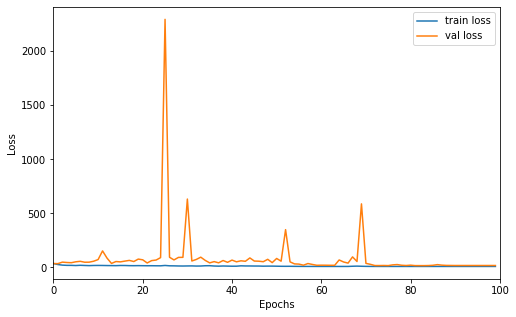

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 5))
plt.plot(train_loss_result,label='train loss')
plt.plot(val_loss_result, label='val loss')
plt.legend()
plt.xlim(0,num_epochs)
plt.xlabel('Epochs')

plt.ylabel('Loss')

Text(0, 0.5, 'Acc')

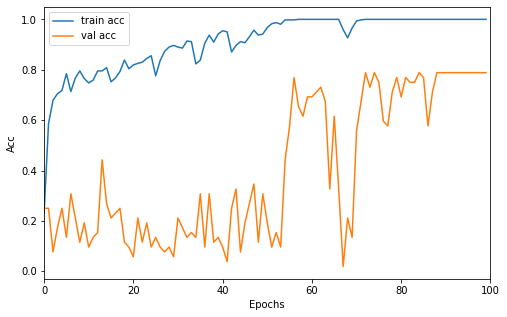

In [3]:
plt.figure(figsize = (8, 5))
plt.plot(train_acc_result,label='train acc')
plt.plot(val_acc_result, label='val acc')
plt.legend()
plt.xlim(0,num_epochs)
plt.xlabel('Epochs')

plt.ylabel('Acc')

Text(0, 0.5, 'Learning rate')

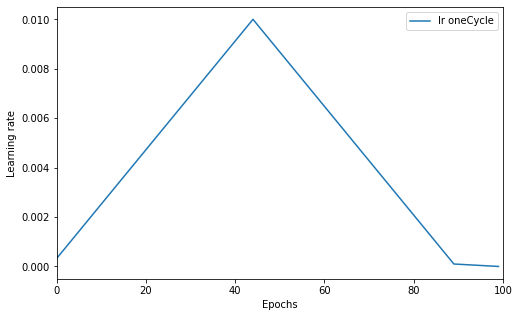

In [4]:
plt.figure(figsize = (8, 5))
plt.plot(lr_oneCycle,label='lr oneCycle')
plt.legend()
plt.xlim(0,num_epochs)
plt.xlabel('Epochs')

plt.ylabel('Learning rate')

In [5]:
from train_basic import *
import os
import shutil
import models
from timm.models import create_model
from models.modules.mobileone import reparameterize_model
import torch
import torch.nn as nn
import torchvision
from dataset_basic import get_transforms, load_data, get_data_loaders
from label_smooth import LabelSmoothingCrossEntropy
import models

#path = './透明_by_CCD/1站'
#path = '大峰2034-07-19-NG/透明'
path = '1020_NG_膠囊_by_CCD/CCD1'
#path = 'CCD1_original_combine_foreground_in_right__rotate90_and-90'
#path = './AAA123/CCD8/Part'
#path = './透明_combine'
bs = 16  # Batch size

transformer = get_transforms()
train, val, test, original = load_data(path, transformer)
loaders = get_data_loaders(train, val, test, bs)

dataset_sizes = {
    'train': len(train),
    'val': len(val),
    'test': len(test),
}
num_epochs_unfreeze = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

############################# ml-fasttvit #################################################################
# num_classes_original = len(original.classes)
# model = create_model("fastvit_t8")
# model_ft = model.to(device)
# model_ft.head = nn.Linear(in_features=model.head.in_features, out_features=num_classes_original, bias=True)

############################# END ##################################################################################

######################### ml-fastvit by another way ###########################################################
# # Assuming other necessary imports are already done
from models import fastvit_t8  # Import the model

# Initialize the model
model = fastvit_t8(pretrained=False)
model.to(device)

# Adapt the final layer if necessary (assuming a classification task)
num_classes_original = len(original.classes)
model_ft = model.to(device)
model_ft.head = nn.Linear(in_features=model.head.in_features, out_features=num_classes_original, bias=True)

# Load pretrained weights if available
# Make sure the format of your checkpoint matches what the model expects
checkpoint_path = './save_model/fastvit_t8_freeze_CCD1_without_augmentation_1219.pt'
#checkpoint = torch.load(checkpoint_path, map_location='cpu')
checkpoint = torch.load(checkpoint_path)
if 'state_dict' in checkpoint:
    model_ft.load_state_dict(checkpoint['state_dict'])
else:
    model_ft.load_state_dict(checkpoint)

#Proceed with the rest of your code for training, validation, etc.



########################### END ##########################################################################


#model_ft.load_state_dict(torch.load('./save_model/fastvit_t8_freeze_CCD1_original_combine_foreground_in_right_rotate90_and-90_1215.pt'))

for param in model_ft.parameters():
    param.requires_grad = True

model_ft = model_ft.to(device)

# Loss function
#criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothingCrossEntropy(reduction='sum')

# Optimizer
optimizer_ft = AdamW(model_ft.parameters(), lr=2.31E-03, betas=(0.9, 0.99), weight_decay=0.01, amsgrad=False)
#optimizer_ft = AdamW(model_ft.parameters(), lr=6.19E-03, betas=(0.9, 0.99), weight_decay=0.01, amsgrad=False)

# Scheduler
exp_lr_scheduler = OneCycleLR(optimizer_ft, lr_range=(1.0E-04, 1.0E-02), num_steps=int(len(loaders['train'])*num_epochs_unfreeze/len(loaders['train'])))

# Train the model
train_loss_result, val_loss_result, train_acc_result, val_acc_result, lr_oneCycle, model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, loaders, dataset_sizes, num_epochs=num_epochs_unfreeze, device=device)

torch.save(model_ft.state_dict(), './save_model/fastvit_t8_unfreeze_CCD1_without_augmentation_1219.pt')


Epoch 0/99
----------
train Loss: 8.3462 Acc: 1.0000
val Loss: 16.5512 Acc: 0.7500

Epoch 1/99
----------
train Loss: 8.3152 Acc: 1.0000
val Loss: 19.2029 Acc: 0.7500

Epoch 2/99
----------
train Loss: 8.2999 Acc: 1.0000
val Loss: 19.0222 Acc: 0.7692

Epoch 3/99
----------
train Loss: 8.2866 Acc: 1.0000
val Loss: 16.4856 Acc: 0.7308

Epoch 4/99
----------
train Loss: 8.2744 Acc: 1.0000
val Loss: 22.6043 Acc: 0.6154

Epoch 5/99
----------
train Loss: 8.2709 Acc: 1.0000
val Loss: 16.3988 Acc: 0.8077

Epoch 6/99
----------
train Loss: 8.2975 Acc: 1.0000
val Loss: 37.7517 Acc: 0.4615

Epoch 7/99
----------
train Loss: 8.3331 Acc: 1.0000
val Loss: 18.8012 Acc: 0.7115

Epoch 8/99
----------
train Loss: 8.3854 Acc: 0.9978
val Loss: 17.9280 Acc: 0.6923

Epoch 9/99
----------
train Loss: 8.4434 Acc: 0.9978
val Loss: 43.4662 Acc: 0.2692

Epoch 10/99
----------
train Loss: 8.5000 Acc: 0.9978
val Loss: 53.6057 Acc: 0.3077

Epoch 11/99
----------
train Loss: 8.4512 Acc: 0.9978
val Loss: 132.5922 Ac

Text(0, 0.5, 'Loss')

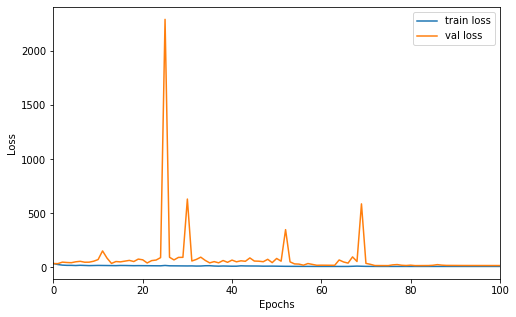

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 5))
plt.plot(train_loss_result,label='train loss')
plt.plot(val_loss_result, label='val loss')
plt.legend()
plt.xlim(0,num_epochs_unfreeze)
plt.xlabel('Epochs')

plt.ylabel('Loss')

Text(0, 0.5, 'Acc')

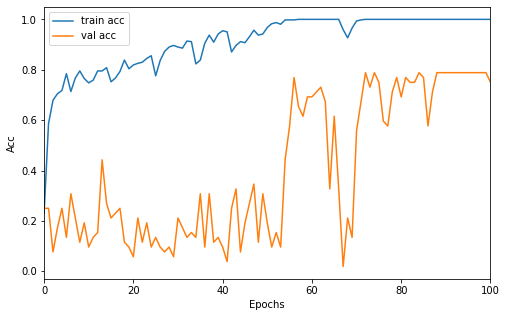

In [7]:
plt.figure(figsize = (8, 5))
plt.plot(train_acc_result,label='train acc')
plt.plot(val_acc_result, label='val acc')
plt.legend()
plt.xlim(0,num_epochs_unfreeze)
plt.xlabel('Epochs')

plt.ylabel('Acc')

Text(0, 0.5, 'Learning rate')

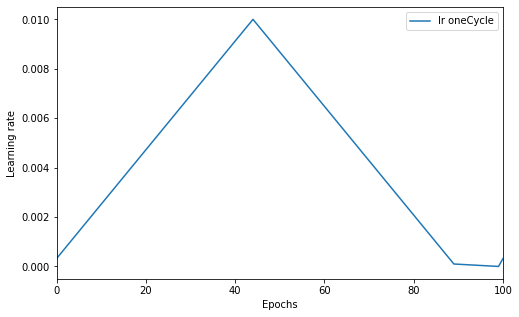

In [8]:
plt.figure(figsize = (8, 5))
plt.plot(lr_oneCycle,label='lr oneCycle')
plt.legend()
plt.xlim(0,num_epochs_unfreeze)
plt.xlabel('Epochs')

plt.ylabel('Learning rate')